### Project - Predict heart attack based on phisiological and physical parameters of the patient

### Action plan

1. Read, explore and clean all the data sets
2. See what all datasets have in common and how to relate them. 
3. Combine or merge relevant columns from datasets 1 and 3, to create a richer dataset. 
4. Plot main relations between variables to better understand the behaviour of the data.
5. Run Machine learning algorithms to train and test. The target is 0 or 1, depending on having or not a stroke.
6. Test all ML models and measure the error. Loop for different model parameters to get the optimal ones.
7. Get best model and run with data set stroke_predictorSet2.csv
8. Measure error. If not high enough, retrain ML models changing parameters.
9. Return best possible ML model to predict stroke with this data.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### First data set analysis and cleaning

1. age
2. sex 1=male, 0=female
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl (100-130 normal, 130-160 above normal, more than 160 well above normal)
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [155]:
df_stroke = pd.read_csv('stroke_predictorSet.csv') 
df_stroke.dropna(inplace=True) #Remove Nan values
original_size = df_stroke.size

df_stroke[df_stroke.duplicated() == True] #Check for duplicates

df_stroke.drop_duplicates(inplace=True) #Remove duplicates and check size of the data frame

#Set appropriate names for the columns
columns = ['Age', 'Sex', 'ChestPain', 'SystolicPressure', 'Cholesterol', 'Diabetes', 'ecgStatus', 'MaxHeartBeat', 'InducedAngina',
           'STdepression','STslope', 'fluorVessels', 'Thalassemia', 'Target']
df_stroke.columns=columns

#Let´s select the columns common to the other datasets in order to compare them
df_stroke.drop(axis=1, columns=['ChestPain', 'ecgStatus', 'MaxHeartBeat', 'InducedAngina', 'STdepression', 'STslope', 'fluorVessels', 'Thalassemia'], inplace=True)

#Clasify Cholesterol column in three categories. (100-130 normal, 130-160 above normal, more than 160 well above normal)
df_stroke['Cholesterol']=pd.cut(df_stroke['Cholesterol'], bins=[0,130,160,1000],right=False, labels=[1,2,3])

#Duplicates were created after segmenting the columns
df_stroke[df_stroke.duplicated()==True].size 
#Remove duplicates
df_stroke.drop_duplicates(inplace=True) 
cleaned_size = df_stroke.size

print('Number of lost samples after cleaning stroke_predictorSet.csv: {:,.0f}%'.format(cleaned_size/original_size*100))
df_stroke.sample(5) #df_stroke clean and features ready for modeling


Number of lost samples after cleaning stroke_predictorSet.csv: 40%


,Age,Sex,SystolicPressure,Cholesterol,Diabetes,Target
275,52,1,125,3,0,0
46,44,1,140,3,0,1
227,35,1,120,3,0,0
61,54,1,108,3,0,1
86,68,1,118,3,0,1


### Second data set analysis and cleaning
1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code | 1 woman, 2 man
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [3]:
df_stroke2 = pd.read_csv('stroke_predictorSet2.csv', sep=';')
df_stroke2.dropna(inplace=True)
original_size2 = df_stroke2.size

df_stroke2[df_stroke2.duplicated() == True] #Check for duplicates. There are no duplicates in this case

#Set appropiate column names for second dataset, according to the data in df_stroke
columns2 = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport','Target']
df_stroke2.columns=columns2

#Age was given in days, transform to years and round to closest integer
df_stroke2['Age']=(df_stroke2['Age']/365).astype(int) 

#Set female to value 0 like in the other datasets
df_stroke2.Sex[df_stroke2['Sex'] == 1] = 0
#set male to 1 like in the other datasets
df_stroke2.Sex[df_stroke2['Sex'] == 2] = 1 

#Let´s select the columns common to the other datasets in order to compare them
#df_stroke2.drop(axis=1, columns=['Id', 'Height','Weight', 'DiastolicPressure', 'Smoker', 'Alcoholic', 'ActiveSport'], inplace=True)

#Caterogize diabetes column in only two catergories, 0 means normal and 1 means above normal or patient with diabetes (>100mg/dl blood sugar)
df_stroke2['Diabetes'] = pd.cut(df_stroke2['Diabetes'], bins=[1,2,4],labels=[0,1], right=False)
df_stroke2['Diabetes'].astype(int)
#Duplicates were created after column segmentation
df_stroke2[df_stroke2.duplicated()==True].size
#Remove duplicates
df_stroke2.drop_duplicates(inplace=True) 
cleaned_size2 = df_stroke2.size

print('Number of lost samples after cleaning stroke_predictorSet2.csv: {:,.0f}%'.format(cleaned_size2/original_size2*100))
df_stroke2.head(5)



Number of lost samples after cleaning stroke_predictorSet2.csv: 100%


,Id,Age,Sex,Height,Weight,SystolicPressure,DiastolicPressure,Cholesterol,Diabetes,Smoker,Alcoholic,ActiveSport,Target
0,0,50,1,168,62.0,110,80,1,0,0,0,1,0
1,1,55,0,156,85.0,140,90,3,0,0,0,1,1
2,2,51,0,165,64.0,130,70,3,0,0,0,0,1
3,3,48,1,169,82.0,150,100,1,0,0,0,1,1
4,4,47,0,156,56.0,100,60,1,0,0,0,0,0


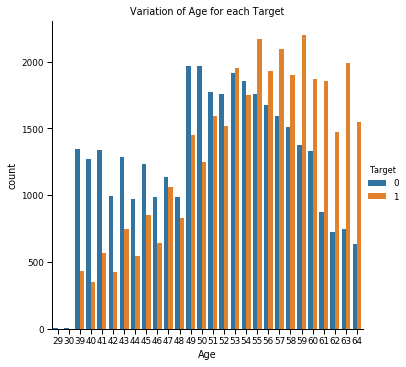

In [5]:
# Plot the target depending on the Age
sns.set_context(context = "paper") 
sns.catplot(kind = 'count', data = df_stroke2, x = 'Age', hue = 'Target', order = df_stroke2['Age'].sort_values().unique());
plt.title('Variation of Age for each Target');

#This behavior makes sense, the older the higher the number of strokes.

### Third data set analysis and cleaning


In [157]:
df_stroke3 = pd.read_csv('stroke_predictoSet3.csv')
df_stroke3.dropna(inplace=True)
original_size3 = df_stroke3.size

#Check for duplicates. There are no duplicates in this case
df_stroke3[df_stroke3.duplicated() == True] 

columns3 = ['Sex', 'Age', 'Education', 'Smoker','CigarretesPerDay', 'BloodPressureMedicines', 'PreviousStroke', 'HyperSentitive', 'Diabetes', 'Cholesterol',
           'SystolicPressure','DiastolicPressure','BodyMassIndex','HeartRate','FastingBloodSugar', 'MoreThanTenYearDisease']
df_stroke3.columns=columns3

df_stroke3.drop(axis=1, columns= ['Education', 'Smoker','CigarretesPerDay', 'BloodPressureMedicines', 'PreviousStroke', 'HyperSentitive','DiastolicPressure','BodyMassIndex','HeartRate', 'FastingBloodSugar', 'MoreThanTenYearDisease'], inplace=True)

#Clasify Cholesterol column in three categories. (100-130 normal, 130-160 above normal, more than 160 well above normal)
df_stroke3['Cholesterol']=pd.cut(df_stroke3['Cholesterol'], bins=[0,130,160,1000],right=False, labels=[1,2,3])

#After removing columns, new duplicates were created. Remove them.
df_stroke3[df_stroke3.duplicated() == True].size
df_stroke3.drop_duplicates(inplace=True) 
cleaned_size3 = df_stroke3.size

print('Number of lost samples after cleaning stroke_predictoSet3.csv: {:,.0f}%'.format(cleaned_size3/original_size3*100))
df_stroke3.sample(5)


Number of lost samples after cleaning stroke_predictoSet3.csv: 23%


,Sex,Age,Diabetes,Cholesterol,SystolicPressure
3496,1,53,0,3,172.5
2461,1,65,0,3,140.0
264,1,57,0,3,134.0
4219,1,48,0,3,125.0
235,0,36,0,2,108.0


### Machine learning models

1. Since df_stroke2 is the largest dataset, we will train models with it. 
2. Select the best model 

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Create target object and call it y
y = df_stroke2['Target']
# Create X
#features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
features = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke2[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.4, random_state=1)

**Decision Tree Regressor**

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
stroke_model = DecisionTreeClassifier(random_state=1)
# Fit Model
stroke_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = stroke_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))


Validation MAE: 0.374


In [29]:
#We define a function that returns the Mean Absolute error of the decision tree
def get_mae_tree(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

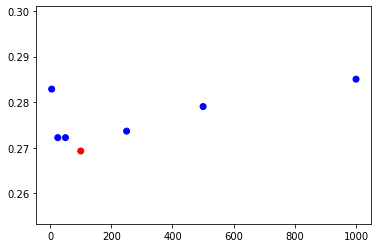

In [30]:
#The error in the first approach is quite high. Let us iterate to find the optimal tree parameters

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500,1000]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
mae=[]
for x in candidate_max_leaf_nodes:
    mae.append(get_mae_tree(x,train_X, val_X, train_y, val_y))

# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[mae.index(min(mae))]

#Show the minimum MAE highlighted in red
minMae = np.min(mae)
mask = np.array(mae) == minMae
color = np.where(mask, 'red', 'blue')
plt.scatter(candidate_max_leaf_nodes,mae, color=color)


In [34]:
#Create optimal tree model
final_tree_model = DecisionTreeClassifier(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model with the whole dataset and calculate error
final_tree_model.fit(train_X, train_y)
val_predictions = final_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f} - Best tree size: {:,.0f}".format(val_mae,best_tree_size))

Validation MAE: 0.269 - Best tree size: 100


In [35]:
final_tree_model.score(val_X,val_y)

0.7307142857142858

In [36]:
print(confusion_matrix(val_y,val_predictions))
print(classification_report(val_y,val_predictions))

[[10420  3379]
 [ 4161 10040]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     13799
           1       0.75      0.71      0.73     14201

    accuracy                           0.73     28000
   macro avg       0.73      0.73      0.73     28000
weighted avg       0.73      0.73      0.73     28000



In [37]:
#Also check the model with cross validation
cross_val_score(final_tree_model, train_X, train_y, cv=5)

array([0.73265087, 0.72991311, 0.73297619, 0.73103941, 0.72901536])

**Random Forest**

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the mean absolute error of your Random Forest model on the validation data
predict_y=rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_y,predict_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))


Validation MAE for Random Forest Model: 0.29828571428571427


In [21]:
#We define a function that returns the Mean Absolute error of the Random Forest. We will check for this purpose
# two parameters of the Random Forest regressor, the depth and the leaf nodes
def get_mae_forest(max_depth, max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = RandomForestClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

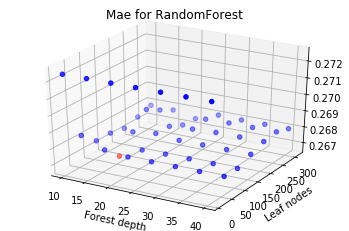

In [22]:
#The error in the first approach is quite high. Let us iterate to find the optimal tree parameters

step_leaf_nodes = 50
step_depth = 5
candidate_max_leaf_nodes = np.arange(10,(step_leaf_nodes*7)+10,step_leaf_nodes)
candidate_max_depth = np.arange(10,(step_depth*7)+10,step_depth)

# Write loop to find the ideal tree size from candidate_max_leaf_nodes and max_depth
mae=[]
depth_points=[]
leaf_points=[]
min_mae=1
for i, x  in enumerate(candidate_max_depth):
    for j, y  in enumerate(candidate_max_leaf_nodes):
        depth_points.append(candidate_max_depth[i])
        leaf_points.append(candidate_max_leaf_nodes[j])
        mae.append(get_mae_forest(x, y, train_X, val_X, train_y, val_y))
        if min(mae) < min_mae:
            min_mae = min(mae)
            # Store the best value of max_leaf_nodes and tree size
            best_depth = candidate_max_depth[i]
            best_tree_size = candidate_max_leaf_nodes[j]

#Show the minimum MAE highlighted in red and plot in 3D the MAE corresponding to the leaf nodes and depth fo the Random Forest
minMae = np.min(mae)
mask = np.array(mae) == minMae
color = np.where(mask, 'red', 'blue')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(depth_points,leaf_points ,mae, color=color);
ax.set_title('Mae for RandomForest');
ax.set_xlabel('Forest depth');
ax.set_ylabel('Leaf nodes');
#ax.set_zlim(zmin= 0.2, zmax=0.5)

In [23]:
#Create optimal random forest model
final_forest_model = RandomForestClassifier(max_depth=best_depth, max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model with the whole dataset and calculate error
final_forest_model.fit(train_X, train_y)
val_predictions = final_forest_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.5f} - Best depth: {:,.0f} - Best tree size: {:,.0f}".format(val_mae, best_depth,best_tree_size))

Validation MAE: 0.26679 - Best depth: 15 - Best tree size: 110


In [24]:
print(confusion_matrix(val_y,val_predictions))
print(classification_report(val_y,val_predictions))

[[10974  2825]
 [ 4645  9556]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75     13799
           1       0.77      0.67      0.72     14201

    accuracy                           0.73     28000
   macro avg       0.74      0.73      0.73     28000
weighted avg       0.74      0.73      0.73     28000



In [27]:
#Also check the model with cross validation
cross_val_score(final_forest_model, train_X, train_y, cv=5)

array([0.73657898, 0.73455541, 0.73369048, 0.73282534, 0.73223003])

### Logistic regression

In [5]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = log.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))

Validation MAE: 0.291


Text(0.5, 1.0, 'ROC Curve')

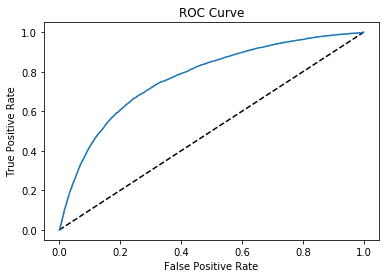

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = log.predict_proba(val_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(val_y, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [8]:
#We compute the area under the ROC
roc_auc_score(val_y, y_pred_prob)

0.7720670422478257

In [9]:
#Also check the model with cross validation
cross_val_score(log, X, y, cv=5, scoring='roc_auc')

array([0.77755714, 0.78756848, 0.78412183, 0.79119275, 0.77978314])

### K-Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(train_X,train_y)

# Predicting the Test set results
val_predictions = knn.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))

Validation MAE: 0.376


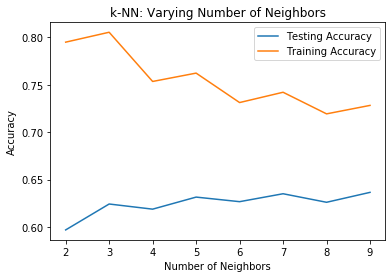

In [62]:
neighbors = np.arange(2, 10)
train_accuracy = []
test_accuracy = []

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(train_X,train_y)    
    #Compute accuracy on the training set
    train_accuracy.append(knn.score(train_X, train_y))
    #Compute accuracy on the testing set
    test_accuracy.append(knn.score(val_X, val_y))
    

#Store the best number of neighbors
best_neighbors = neighbors[train_accuracy.index(max(train_accuracy))]

# Generate plot
plt.title('k-NN: Varying Number of Neighbors');
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy');
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy');
plt.legend()
plt.xlabel('Number of Neighbors');
plt.ylabel('Accuracy');

In [63]:
#Create optimal random forest model
final_neighbor_model = KNeighborsClassifier(n_neighbors=best_neighbors)

# fit the final model with the whole dataset and calculate error
final_neighbor_model.fit(train_X, train_y)
val_predictions = final_neighbor_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.5f} - Best number of neighbors: {:,.0f}".format(val_mae, best_neighbors))

Validation MAE: 0.37575 - Best number of neighbors: 3


In [65]:
#Also check the model with cross validation
cross_val_score(final_neighbor_model, train_X, train_y, cv=5)

array([0.61825973, 0.61397453, 0.61821429, 0.61971663, 0.62412192])

### Light GBM

In [108]:
import lightgbm as lgb

d_train = lgb.Dataset(train_X, label = train_y)
params = {}

clf = lgb.train(params, d_train, 100)
#Prediction
val_predictions = clf.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))

Validation MAE: 0.359


### Support Vector Machine (SVC)

In [ ]:

'''from sklearn.preprocessing import StandardScaler as ss
sc = ss()
X_train = sc.fit_transform(train_X)
X_test = sc.transform(val_X)'''

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = classifier.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))


### Naive Bayes

In [12]:

from sklearn.naive_bayes import GaussianNB
gaussModel = GaussianNB()
gaussModel.fit(train_X, train_y)

# Predicting the Test set results
val_predictions = gaussModel.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))


Validation MAE: 0.463


### XGBoost model

In [23]:
import xgboost as xgb
from xgboost import XGBRegressor

features = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Smoker', 'Alcoholic',
           'ActiveSport']
X = df_stroke2[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [26]:
xgbModel = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.1)

xgbModel.fit(train_X,train_y)

[19:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
val_predictions = xgbModel.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))

Validation MAE: 0.361
